# Preprocessing Data: DataFrame with Pandas

The data is split into 2 CSV files, true and fake news. We will first view the two files seperately and then merge in order to split into train and test datasets. 

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


In [101]:
# Import dependencies
import io
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
#from sklearn.preprocessing import StandardScaler
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [71]:
# Spark dependencies 
import os
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'

os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
tar: spark-3.0.3-bin-hadoop2.7.tgz: Cannot open: No

Exception: ignored

In [7]:
#  Import and read the Fake.csv.
fake_news_df = pd.read_csv(io.BytesIO(uploaded['Fake.csv']))
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
fake_news_df.nunique()

title      17903
text       17455
subject        6
date        1681
dtype: int64

In [9]:
fake_news_df['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [10]:
#  Import and read the True.csv.
true_news_df = pd.read_csv(io.BytesIO(uploaded['True.csv']))
true_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
true_news_df.nunique()

title      20826
text       21192
subject        2
date         716
dtype: int64

In [12]:
true_news_df['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [13]:
# Label fake and real data 0 and 1 
true_news_df['label']=1
fake_news_df['label']=0

In [14]:
# Merge dfs
frames = [true_news_df, fake_news_df]
real_or_fake_df = pd.concat(frames)

# Drop subject columns as will skew the data 
real_or_fake_df=real_or_fake_df.drop(columns=['subject'],axis=1)
# Drop date column as data not needed 
real_or_fake_df=real_or_fake_df.drop(columns=['date'],axis=1)

In [15]:
real_or_fake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [16]:
real_or_fake_df.duplicated().sum()

5793

In [17]:
real_or_fake_df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [18]:
real_or_fake_df.drop_duplicates()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
22698,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,0
22699,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,0
22700,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,0
22701,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,0


In [19]:
real_or_fake_df.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [ ]:
# ANY VISUALISATIONS?
# plot time period
# plot subjects 
# word clouds?
# pie chart fake and true 

# Preprocessing Data: NLP with tokenize

In [118]:
# tokenize titles into words 
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
alpha_token = RegexpTokenizer(r'[A-Za-z]+')

title = real_or_fake_df['title']
title_tokenized = []
for title in title:
  title_tokens = tokenizer.tokenize(title)
 # alpha_only = alpha_token.tokenize(title_tokens)
  #title_tokens = word_tokenize(title)
  #lower_title_tokens = title_tokens.lower()
  # delete punctuation 
  # delete numbers 
  # delete special characters 
  title_tokenized.append(title_tokens)

# Frequency list of words in titles
freq_words = [len(title_tokens) for title_tokens in title_tokenized]

In [113]:
print(title_tokenized[1])

['U', 'S', 'military', 'to', 'accept', 'transgender', 'recruits', 'on', 'Monday', 'Pentagon']


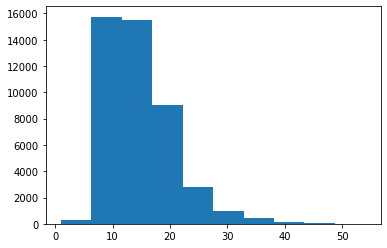

In [94]:
# plot hist of sentence lengths for titles 
plt.hist(freq_words)
plt.show()

In [96]:
# Bag of words to see most common tokens (SHAN ONLY USE THIS IF DF DOESN'T WORK)
# instantiate WordNetLennatizer
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatize into new list 
lemmatized = [wordnet_lemmatizer.lemmatize(title) for title in title_tokenized]
bow = Counter(lemmatized)
print(bow.most_common(10))

TypeError: ignored

In [108]:
#real_or_fake_df['tokenized_titles'] = real_or_fake_df.apply(lambda row: word_tokenize(row['title']), axis=1)

In [ ]:
#real_or_fake_df

# Train & Test Model

In [114]:
y = real_or_fake_df['label']
X = title_tokenized
# shan change this to tokenized words 

In [115]:
# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
# count vector - how many times does each word appear in titles?
# shan, go back and change count vc to TFIDF as it counts but also signifiers a higher importance of words 
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

AttributeError: ignored

In [116]:
# Initalize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.fit_transform(X_test)

AttributeError: ignored

In [29]:
# Convert into df
# order by top weighthed words 
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

ValueError: ignored

In [ ]:
# Classification Model: Naive Bayes Classifier
# Multinomial Naive Bayes classifier has been used as the data is discrete 
nb_classifier = MultinomialNB()

nb_classifier.fit(tfidf_train, y_train)

pred = nb_classifier.predict(tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print(score)

In [ ]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, pred, labels=['fake', 'real'])
print(confusion_matrix)

In [ ]:
# sequential model or another model to compare?

# Model Optimisation